In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scipy.stats as stats
import csv
import pickle

In [2]:
# load review and listing data
filePath = "../Data/"
# data source: https://drive.google.com/open?id=1cWcZlf8gOj-NBq5fPEOT8dmOpC9bvbiA
listing = pd.read_csv(filePath+"listings_cleaned.csv")  # use cleaned listing to join with review data
review = pd.read_csv(filePath+"reviews.csv", parse_dates=[2])
  # Dataset accessible from https://drive.google.com/open?id=1dXZznho8BpLjP851AmWfdGGAGrJRkUe7
# review = pickle.load( open( filePath+"reviews.p", "rb" ) )

## Subset data to only keep reviews written in 2017
### (can skip this step if have the pickle file)

In [3]:
review["year"] = review["date"].apply(lambda t: t.year)

In [ ]:
review.year.hist()

In [4]:
review2017 = review[review.year == 2017]

In [5]:
# sort by review date
review2017.sort_values(by = "date", inplace= True)
review2017 = review2017.reset_index()

D:\Anaconda3\envs\data-x\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Group by listing id. concatenate

In [11]:
# drop irrelevant cols
review2017 = review2017.loc[:,["listing_id","comments"]]

# create a counter col
review2017["ct"] = np.ones((review2017.shape[0],1), dtype= np.int8)

In [12]:
# drop rows with missing comments
review2017.dropna(inplace=True)

In [14]:
pickle.dump(review2017, open( filePath+"review2017.p", "wb" ) )

In [3]:
# load intermediate result: review data from 2017
filePath = "../Data/"
review2017 = pickle.load( open( filePath+"review2017.p", "rb" ) )

In [19]:
# convert all comments to str
review2017["comments"] = review2017["comments"].apply(str)
review2017_by_list_id = review2017.groupby(by = "listing_id")["comments"].apply(lambda x: " ".join(x))
review2017_by_list_id = pd.DataFrame(review2017_by_list_id)

# Add up number of reviews per listing
review2017_by_list_id["ct"] = review2017.groupby(by = "listing_id")["ct"].sum()

In [21]:
# review2017_by_list_id.head()

,comments,ct
listing_id,,
2708,ホストはとても親切で英語の発音の仕方など丁寧に教えてくれた。\n\n部屋はリビングを板で仕切...,1.0
2732,Havde en fantastisk tid hos Yoga Priestess. Et...,2.0
3021,"Quartier charmant, vert et au calme sans être ...",3.0
5728,Lovely and cozy room So funky. I loved it Thi...,66.0
5729,Very zen and quiet space....bringing nature in...,50.0


In [22]:
review2017_by_list_id = review2017_by_list_id.reset_index()

In [23]:
# make sure all id from review data set is int

# validId = [ID for ID in review2017_by_list_id.id.values if isinstance(ID, int)]
# review2017_by_list_id.drop(index=20243, inplace=True)  # this row's id is "id"

review2017_by_list_id.set_axis(["id","review","ct"], axis=1)
review2017_by_list_id["id"] = review2017_by_list_id["id"].apply(lambda x: int(x))

D:\Anaconda3\envs\data-x\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [24]:
# review2017_by_list_id.head()

,id,review,ct
0,2708,ホストはとても親切で英語の発音の仕方など丁寧に教えてくれた。\n\n部屋はリビングを板で仕切...,1.0
1,2732,Havde en fantastisk tid hos Yoga Priestess. Et...,2.0
2,3021,"Quartier charmant, vert et au calme sans être ...",3.0
3,5728,Lovely and cozy room So funky. I loved it Thi...,66.0
4,5729,Very zen and quiet space....bringing nature in...,50.0


## Left join `listing` and `review2017_by_list_id` by listing ID
### Note: for each review, we have to have a corresponding zipcode which is in `listing`

In [25]:
merged = pd.merge(listing, review2017_by_list_id, on="id", how='left')

## Aggregate review by zipcode

In [26]:
# merged.head()
# only keep zip code and review
merged = merged.filter(items= ["zipcode","review","ct"], axis=1)

In [27]:
# fill NaN in review with empty string
merged["review"].fillna("", inplace = True)

In [28]:
# for reviews corresponding to the same zipcode, concatenate them
review_by_zipcode = merged.groupby(by = "zipcode")["review"].apply(lambda x: " ".join(x))
review_by_zipcode = pd.DataFrame(review_by_zipcode)

review_by_zipcode["ct"] = merged.groupby(by = "zipcode")["ct"].sum()
# now if the review value is an empty string, it means for the given zipcode, there are no corresponding reviews in year 2017.

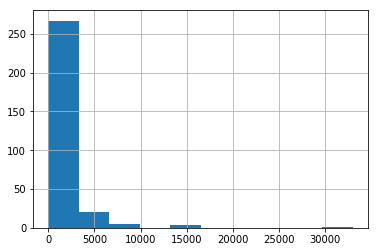

In [30]:
# review_by_zipcode.ct.hist()

## Output intermediate result to csv file for collaboration/efficiency

In [35]:
review_by_zipcode.to_csv(filePath+"review_by_zipcode.csv", header= True)

In [39]:
pickle.dump(review_by_zipcode, open( filePath+"review_by_zipcode.p", "wb" ) )